# Tohoku tsunami inversion

Try solving the wave equation instead

In [1]:
%matplotlib inline

In [2]:
from thetis import *
from firedrake_adjoint import *

In [3]:
import matplotlib.pyplot as plt

In [4]:
from adapt_utils.case_studies.tohoku.options.options import TohokuInversionOptions
from adapt_utils.misc import gaussian, ellipse

In [5]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

### Forward model

In [7]:
level = 0
op = TohokuInversionOptions(level=level)
gauges = list(op.gauges.keys())
print(gauges)
op.end_time = 60*30
op.dt = 4*0.5**level

['801', '802', '803', '804', '806', '807', 'P02', 'P06', 'KPG1', 'KPG2', 'MPG1', 'MPG2', '21401', '21413', '21418', '21419']


In [8]:
mesh = op.default_mesh
P1 = FunctionSpace(mesh, "CG", 1)
P0 = FunctionSpace(mesh, "DG", 0)

In [9]:
b = Function(P1).assign(op.set_bathymetry(P1))
g = Constant(op.g)
c_sq = g*b

In [10]:
dtc = Constant(op.dt)
dtc_sq = Constant(op.dt**2)
n = FacetNormal(mesh)

eta = TrialFunction(P1)
phi = TestFunction(P1)
eta_ = Function(P1)
eta__ = Function(P1)

a = inner(eta, phi)*dx
L = inner(2*eta_ - eta__, phi)*dx - dtc_sq*inner(c_sq*grad(eta_), grad(phi))*dx
# L += dtc_sq*phi*c_sq*dot(grad(eta_), n)*ds

eta = Function(P1)
params = {
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "pc_type": "sor",
}
prob = LinearVariationalProblem(a, L, eta, bcs=DirichletBC(P1, 0, 100))
solver = LinearVariationalSolver(prob, solver_parameters=params)

# Source model

In [11]:
eta0 = Function(P1)
loc = (0.7e+06, 4.2e+06)
radii = (48e+03, 96e+03)
angle = pi/12
eta0.interpolate(10*gaussian([loc + radii], mesh, rotation=angle));

In [12]:
radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
for gauge in gauges:
    loc = op.gauges[gauge]["coords"]
    op.gauges[gauge]['indicator'] = interpolate(ellipse([loc + (radius,)], mesh), P0)
    area = assemble(op.gauges[gauge]['indicator']*dx)
    op.gauges[gauge]['indicator'].assign(op.gauges[gauge]['indicator']/area)
    op.sample_timeseries(gauge, sample=op.gauges[gauge]['sample'], detide=True)

## Forward solve

Now run the forward model, time integrating the QoI as time progresses.

In [13]:
def solve_forward(init):
    eta_.assign(init)
    eta__.assign(init)
    t = op.dt
    J = 0
    iteration = 0
    wq = Constant(0.5)
    eta_obs = Constant(0.0)
    for gauge in gauges:
        op.gauges[gauge]['init'] = None
        if t < op.gauges[gauge]['arrival_time']:
                continue
        op.gauges[gauge]['init'] = eta__.at(op.gauges[gauge]['coords'])
        eta_obs.assign(op.gauges[gauge]['init'])
        J = J + assemble(wq*op.gauges[gauge]['indicator']*(eta__ - eta_obs)**2*dx)
        J = J + assemble(wq*op.gauges[gauge]['indicator']*(eta_ - eta_obs)**2*dx)
    while t < op.end_time:
        if iteration % 15 == 0:
            print("t = {:2.0f} mins".format(t/60))

        # Solve forward equation at current timestep
        solver.solve()
        eta__.assign(eta_)
        eta_.assign(eta)
        t += op.dt
        iteration += 1

        # Time integrate QoI
        for gauge in op.gauges:
            if t < op.gauges[gauge]['arrival_time']:
                continue
            elif np.isclose(t, op.gauges[gauge]['arrival_time']):
                wq.assign(0.5*0.5*op.dt)
            elif np.isclose(t, op.gauges[gauge]['departure_time']):
                wq.assign(0.5*0.5*op.dt)
            elif t > op.gauges[gauge]['departure_time']:
                continue
            else:
                wq.assign(0.5*1.0*op.dt)
                
            # Interpolate observations
            if op.gauges[gauge]['init'] is None:
                op.gauges[gauge]['init'] = eta.at(op.gauges[gauge]['coords'])
            eta_obs.assign(float(op.gauges[gauge]['interpolator'](t)) + op.gauges[gauge]['init'])

            # Continuous form of error
            J = J + assemble(wq*op.gauges[gauge]['indicator']*(eta - eta_obs)**2*dx)

    assert np.allclose(t, op.end_time), "mismatching end time ({:.2f} vs {:.2f})".format(t, op.end_time)
    return J

Define gauge indicators

In [14]:
c = Control(eta0)
J = solve_forward(eta0)
print("Quantity of interest = {:.4e}".format(J))

t =  0 mins
t =  1 mins
t =  2 mins
t =  3 mins
t =  4 mins
t =  5 mins
t =  6 mins
t =  7 mins
t =  8 mins
t =  9 mins
t = 10 mins
t = 11 mins
t = 12 mins
t = 13 mins
t = 14 mins
t = 15 mins
t = 16 mins
t = 17 mins
t = 18 mins
t = 19 mins
t = 20 mins
t = 21 mins
t = 22 mins
t = 23 mins
t = 24 mins
t = 25 mins
t = 26 mins
t = 27 mins
t = 28 mins
t = 29 mins
Quantity of interest = 2.2486e+04


<AxesSubplot:title={'center':'Free surface'}>

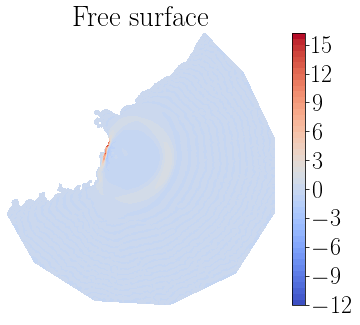

In [15]:
eta.dat.name = 'Free surface'
plot_field(eta);

## Discrete adjoint

Note that we only Taylor test the elevation and effectively zero out the perturbation away from the source.

In [16]:
stop_annotating();

In [17]:
Jhat = ReducedFunctional(J, c)

In [18]:
np.random.seed(0)
m0 = Function(eta0)
m0.dat.data[:] *= 0.7
dm0 = Function(P1)
dm0.dat.data[:] = np.random.rand(*dm0.dat.data.shape)*m0.dat.data
m0 += dm0
minconv = taylor_test(Jhat, m0, dm0)
assert minconv > 1.90, minconv

Running Taylor test
Computed residuals: [0.31301339283885454, 0.078136270105432, 0.019475527868038967, 0.004839613449796332]
Computed convergence rates: [2.002160092643211, 2.0043299571448663, 2.008698705772561]


Check CFL criterion

In [19]:
interpolate(CellSize(mesh)/sqrt(g*b), P1).vector().gather().min()

75.72702979848377

In [20]:
interpolate(CellSize(mesh)/sqrt(g*b), P0).vector().gather().min()

68.79456277520275